# Preprocessing the original data 
Basic EDA and creating dataset for modeling.

### Load the original data and clean it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Read sensors dataset
df = pd.read_csv("../data/raw/data_v2.csv", parse_dates=["time"])
# Read the metadata
pf = pd.read_csv("../data/raw/metadata.csv")

In [3]:
df.head()

,time,source_address,parameter_name,parameter_value
0,2022-08-15 00:00:15.986,1786944289,shtc3_humidity,48.94
1,2022-08-15 00:00:15.986,1786944289,shtc3_temperature,22.07
2,2022-08-15 00:00:25.205,614953587,shtc3_humidity,49.73
3,2022-08-15 00:00:25.205,614953587,shtc3_temperature,21.82
4,2022-08-15 00:00:26.089,926036168,shtc3_humidity,49.50


In [4]:
pf = pf.set_index('source_address')
pf

,x_position,y_position,z_position,device_type
source_address,,,,
2062404276,111,15,0,lamp
367818600,185,15,0,lamp
1307336718,200,15,0,lamp
2050868026,215,15,0,lamp
160784073,230,15,0,lamp
465407368,245,15,0,lamp
730804714,170,15,0,lamp
1629094469,155,15,0,lamp
924241205,140,15,0,lamp


In [5]:
# Get all the source_address of lamps in a list, sorted by x_position
lamps = [x for x in pf[pf['device_type'] == 'lamp'].sort_values(by = ['x_position']).index ]

# Get all the source_adress of external sensors in a list, sorted by x_position
sensors = [x for x in pf[pf['device_type'] == 'external_sensor'].sort_values(by = ['x_position']).index ]
sensors

[1916751226,
 614953587,
 1012045058,
 1566931549,
 2132706098,
 1815204248,
 2099571705,
 926036168,
 1786944289]

In [6]:
# Pivot the sensor dataset
table = pd.pivot_table(df, values='parameter_value', index=[ 'source_address', 'time'],

                    columns=['parameter_name'])
# table_temp = table.copy()
# table.head()

In [7]:
# Merge both dataframes into one big one
data = table.join(pf.reindex(table.index, level=0))

In [8]:
# Check for duplicates
np.sum(data.duplicated())

107403

In [9]:
# Drop duplicates
data.drop_duplicates(keep='first', inplace=True)
data.shape

(1064331, 12)

In [10]:
# Create a lookup with match external sensors to lamps (nearest)

# Initialize the columns
pf['source_address_external'] = -1
pf['x_pos_sensor'] = -1

# Matching external sensors to each lamp
for address in pf.reset_index()[pf.reset_index()['device_type'] == 'lamp']['source_address']:
    x_pos_lamp =  pf.loc[address]['x_position']
    pf_sort = pf[pf['device_type'] == 'external_sensor'].iloc[(pf[pf['device_type'] == 'external_sensor']['x_position']-x_pos_lamp).abs().argsort()[:1]]
    pf.at[address,'source_address_external'] = pf_sort.index.tolist()[0]
    pf.at[address,'x_pos_sensor'] = pf_sort['x_position']
    
# Lookup table with matching lamps and senors    
pf_lamp_sensor = pf[pf['device_type'] == 'lamp']
pf_lamp_sensor

C:\Users\Anita\AppData\Local\Temp\ipykernel_15032\2705208380.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pf_sort = pf[pf['device_type'] == 'external_sensor'].iloc[(pf[pf['device_type'] == 'external_sensor']['x_position']-x_pos_lamp).abs().argsort()[:1]]


,x_position,y_position,z_position,device_type,source_address_external,x_pos_sensor
source_address,,,,,,
2062404276,111,15,0,lamp,1916751226,111
367818600,185,15,0,lamp,2132706098,185
1307336718,200,15,0,lamp,1815204248,195
2050868026,215,15,0,lamp,2099571705,215
160784073,230,15,0,lamp,2099571705,215
465407368,245,15,0,lamp,926036168,245
730804714,170,15,0,lamp,1566931549,155
1629094469,155,15,0,lamp,1566931549,155
924241205,140,15,0,lamp,1012045058,147


In [11]:
# Save this for further use in detect_anomalies
# pf_lamp_sensor.to_csv('../data/processed/lamp_to_sensor_table_raw.csv')

### Prepare sampled dataset. 

In [12]:
# Resample for the whole original dataframe 

slot = '5min' # '10min', '5min'

data = data.reset_index('source_address').groupby('source_address', group_keys=False).resample(slot).nearest().reset_index()

In [13]:
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data.set_index(['source_address', 'time'], inplace=True)


In [14]:
data.head(10)

light_state  local_detections  \
source_address time                                                 
160784073      2022-08-15 00:00:00          2.0           23565.0   
               2022-08-15 00:05:00          2.0           23565.0   
               2022-08-15 00:10:00          2.0           23565.0   
               2022-08-15 00:15:00          2.0           23565.0   
               2022-08-15 00:20:00          2.0           23565.0   
               2022-08-15 00:25:00          2.0           23565.0   
               2022-08-15 00:30:00          2.0           23565.0   
               2022-08-15 00:35:00          2.0           23565.0   
               2022-08-15 00:40:00          2.0           23565.0   
               2022-08-15 00:45:00          2.0           23565.0   

                                    sht40_humidity  sht40_temperature  \
source_address time                                                     
160784073      2022-08-15 00:00:00           25.74              34.18   
               2022-08-15 00:05:00           25.67              34.23   
               2022-08-15 00:10:00           25.67              34.21   
               2022-08-15 00:15:00           25.74              34.21   
               2022-08-15 00:20:00           25.81              34.18   
               2022-08-15 00:25:00           25.81              34.21   
               2022-08-15 00:30:00           25.67              34.18   
               2022-08-15 00:35:00           25.60              34.15   
               2022-08-15 00:40:00           25.74              34.18   
               2022-08-15 00:45:00           25.87              34.12   

                                    shtc3_humidity  shtc3_temperature  \
source_address time                                                     
160784073      2022-08-15 00:00:00             NaN                NaN   
               2022-08-15 00:05:00             NaN                NaN   
               2022-08-15 00:10:00             NaN                NaN   
               2022-08-15 00:15:00             NaN                NaN   
               2022-08-15 00:20:00             NaN                NaN   
               2022-08-15 00:25:00             NaN                NaN   
               2022-08-15 00:30:00             NaN                NaN   
               2022-08-15 00:35:00             NaN                NaN   
               2022-08-15 00:40:00             NaN                NaN   
               2022-08-15 00:45:00             NaN                NaN   

                                    total_normalized_energy  \
source_address time                                           
160784073      2022-08-15 00:00:00                 219515.0   
               2022-08-15 00:05:00                 219515.0   
               2022-08-15 00:10:00                 219515.0   
               2022-08-15 00:15:00                 219515.0   
               2022-08-15 00:20:00                 219515.0   
               2022-08-15 00:25:00                 219515.0   
               2022-08-15 00:30:00                 219515.0   
               2022-08-15 00:35:00                 219515.0   
               2022-08-15 00:40:00                 219515.0   
               2022-08-15 00:45:00                 219515.0   

                                    wsen_pads_temperature  x_position  \
source_address time                                                     
160784073      2022-08-15 00:00:00                  34.44         230   
               2022-08-15 00:05:00                  34.43         230   
               2022-08-15 00:10:00                  34.43         230   
               2022-08-15 00:15:00                  34.41         230   
               2022-08-15 00:20:00                  34.40         230   
               2022-08-15 00:25:00                  34.42         230   
               2022-08-15 00:30:00                  34.40         230   
               2022-08-15 00:35:00     

### Create averaged dataframe over lamps and sensors and visualise it.

In [15]:
# Preparing the averaged table
data_avg = data.reset_index().drop(labels = ['device_type', 'x_position', 'y_position', 'z_position','source_address'], axis = 1).groupby('time').agg('mean')
data_avg.reset_index(inplace = True)

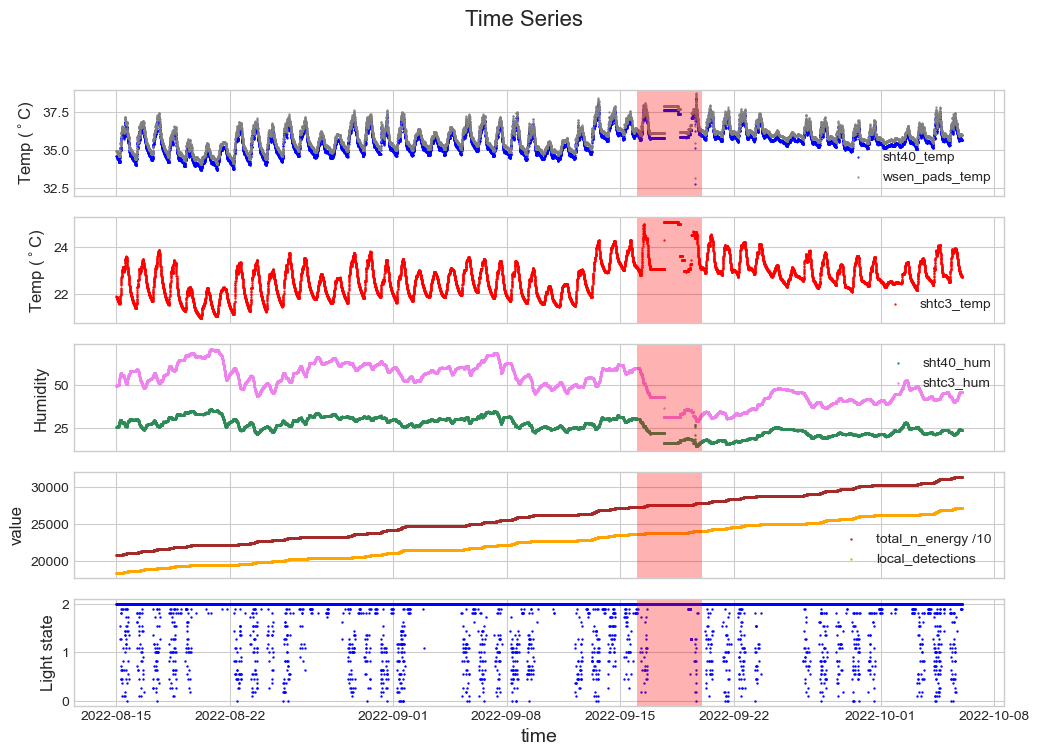

In [16]:
# Plot all the features - averaged data; in red marked time to be removed
with plt.style.context('seaborn-whitegrid'):

    fig, ([ax1, ax2, ax3, ax4, ax5]) = plt.subplots(nrows=5, ncols = 1, sharex=True,  figsize = (12,8))
    fig.suptitle('Time Series', fontsize=16)

    ax1.scatter(data_avg['time'], data_avg['sht40_temperature'], color = 'blue', s=0.3, label = "sht40_temp")
    ax1.scatter(data_avg['time'], data_avg['wsen_pads_temperature'], color = 'gray', s=0.3, label = "wsen_pads_temp")
    ax1.axvspan( xmin = pd.to_datetime('2022-09-16'), 
            xmax = pd.to_datetime('2022-09-20'),            
            facecolor ='red', alpha = 0.3)

    ax1.set_ylim(32,39)
    ax1.legend(loc="lower right", fontsize = 10)
    ax1.set_ylabel("Temp ($^\circ$C)", fontsize = 12)
    
    ax2.scatter(data_avg['time'], data_avg['shtc3_temperature'], color = 'red', s=0.4, label = 'shtc3_temp')
    ax2.legend(loc="lower right", fontsize = 10)
    ax2.set_ylabel("Temp ($^\circ$C)", fontsize = 12)
    ax2.axvspan( xmin = pd.to_datetime('2022-09-16'), 
            xmax = pd.to_datetime('2022-09-20'),            
            facecolor ='red', alpha = 0.3)
    # ax[1].set_ylim(32,39)
    
   
    ax3.scatter(data_avg['time'], data_avg['sht40_humidity'], color = 'seagreen', s=0.5, label = "sht40_hum")
    ax3.scatter(data_avg['time'], data_avg['shtc3_humidity'], color = 'violet', s=0.5, label = "shtc3_hum")
    ax3.axvspan( xmin = pd.to_datetime('2022-09-16'), 
            xmax = pd.to_datetime('2022-09-20'),            
            facecolor ='red', alpha = 0.3)
    ax3.set_ylabel("Humidity", fontsize = 12)
    ax3.legend(loc="upper right", fontsize = 10)
    
    
    ax4.scatter(data_avg['time'], data_avg['total_normalized_energy']/10, color = 'brown', s=0.5, label = "total_n_energy /10")
    ax4.scatter(data_avg['time'], data_avg['local_detections'], color = 'orange', s=0.5, label = "local_detections")
    ax4.axvspan( xmin = pd.to_datetime('2022-09-16'), 
            xmax = pd.to_datetime('2022-09-20'),            
            facecolor ='red', alpha = 0.3)
    ax4.set_ylabel("value", fontsize = 12)
    ax4.legend(loc="lower right", fontsize = 10)
    
    ax5.scatter(data_avg['time'], data_avg['light_state'], color = 'blue', s=0.5, label = "light_state")
    
    ax5.axvspan( xmin = pd.to_datetime('2022-09-16'), 
            xmax = pd.to_datetime('2022-09-20'),            
            facecolor ='red', alpha = 0.3)
    ax5.set_ylabel("Light state", fontsize = 12)

    ax5.set_xlabel("time", fontsize = 14)

    plt.show()
# fig.savefig('data_raw_avg.png',dpi=300,bbox_inches='tight')

### Create dataset with single lamps and corresponding sensors.

In [17]:
# Creating a df with lamps and corresponding sensor data together, one by one, no averaging, according to the lookup table pf_lamp_sensor

data = data.drop(labels = ['device_type', 'x_position', 'y_position', 'z_position'], axis = 1)
df_singles = pd.DataFrame(columns=data.reset_index().columns)
df_singles.set_index(['source_address', 'time'], inplace=True)
df_singles

,,light_state,local_detections,sht40_humidity,sht40_temperature,shtc3_humidity,shtc3_temperature,total_normalized_energy,wsen_pads_temperature
source_address,time,,,,,,,,


In [18]:
for address in pf_lamp_sensor.index:
    sub_df = data.xs(address, level=0, drop_level = False).copy() # sub data frame with lamp data
    delta_energy = sub_df['total_normalized_energy'].diff() # total energy is cummulative, therefore we change to the one released per time slot
    delta_energy.iloc[0] = 0
    sub_df.loc[:,'delta_energy'] = delta_energy   
    sensor_address = pf_lamp_sensor.loc[address]['source_address_external'] # lookup the corresponding sensor address for a given lamp
    sub_sensor_address = data.xs(sensor_address, level=0, drop_level = False) # create sub data frame with sensor data
   # add columns from sensor data to the lamp data
    sub_df.drop(labels = ['shtc3_temperature', 'shtc3_humidity'], axis =1, inplace = True)
    sub_df.reset_index('source_address', inplace = True)
    sub_sensor_address.reset_index('source_address',inplace = True)
    sub_df = sub_df.join(sub_sensor_address[['shtc3_temperature', 'shtc3_humidity']])
    # remove rows with no values (NaN) of real temperature 
    sub_df = sub_df[sub_df['shtc3_temperature'].notna()]
    sub_df.reset_index(inplace = True)
    sub_df.set_index(['source_address', 'time'], inplace=True)
    df_singles = pd.concat([df_singles,sub_df])

# Remove negative energy release
df_singles['delta_energy'] = df_singles['delta_energy'].apply(lambda x : x if x > 0 else 0)

In [19]:
# Remove problematic dates, when devices were unplugged

start = pd.to_datetime('2022-09-16')
stop = pd.to_datetime('2022-09-20')

df_singles.reset_index(inplace = True)
df_singles = df_singles.loc[(df_singles['time'] < start) | (df_singles['time'] > stop)].copy()

In [20]:
df_singles.set_index('source_address', inplace = True)

In [21]:
# Save this data set of matching lamps and sensors for further use in detect_anomalies
# df_singles.to_csv('../data/processed/data_5min_single_lamps_single_sensors.csv')

### EDA

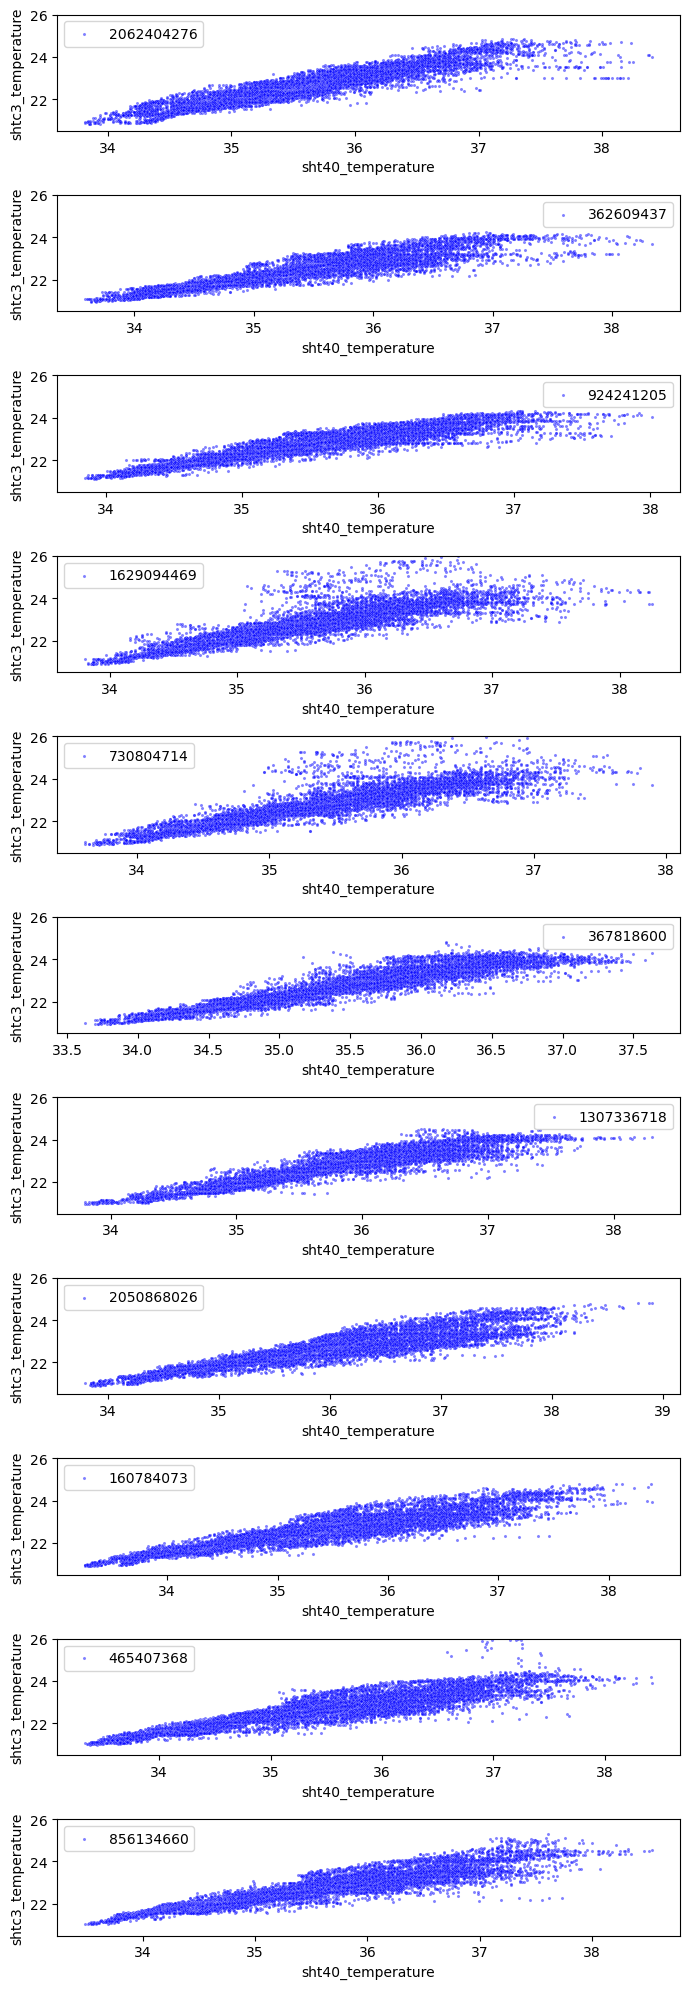

In [22]:
# Plot temperature real vs temperature lamp
# Sensor no. 1566931549 at the x_position = 155 shows some higher values and therefore there is a spread of the data in the 2 figs  below, which have included this sensor
size = 5

fig, axes = plt.subplots(len(lamps), 1)
fig.set_figheight(20)
fig.set_figwidth(7)
# fig.subplots_adjust(hspace = .5, wspace=.001)
# axs = axs.ravel()
for i in range(len(lamps)):
    sns.scatterplot(ax = axes[i],data = df_singles.loc[lamps[i]], x='sht40_temperature', y='shtc3_temperature', s=size, alpha=.5, color = 'blue', label = lamps[i]); # hue = 'source_address', 
    axes[i].set_ylim(20.5, 26)
    
    
plt.tight_layout()  
plt.show()

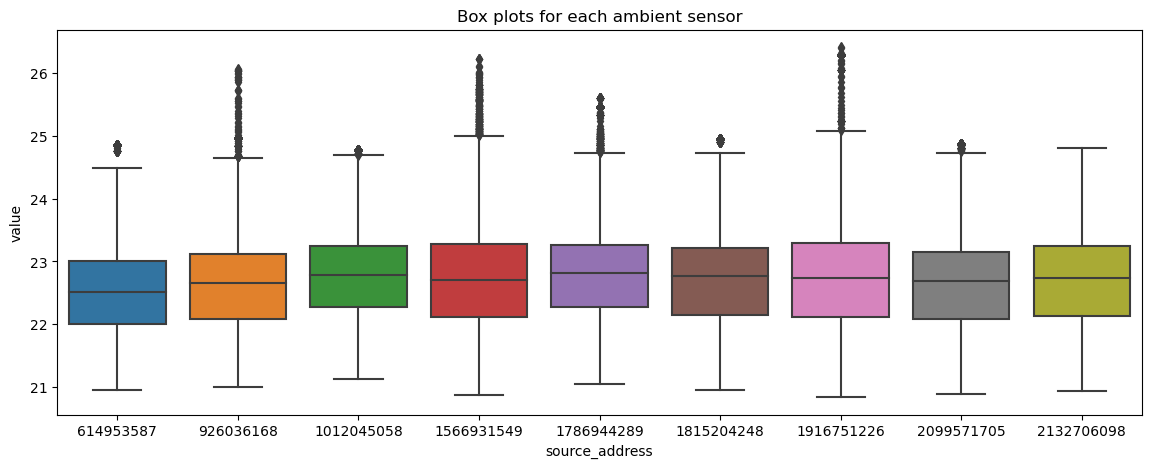

In [23]:
# Box plots for all the sensors
df_sensors = data.reset_index()[~(data.reset_index()['source_address'].isin(lamps))].set_index('source_address')

test = df_sensors[['shtc3_temperature']].reset_index()
test2 = test.pivot(columns='source_address', values='shtc3_temperature')
fig, ax = plt.subplots(1,1, figsize = (14,5))
ax = sns.boxplot(x="source_address", y="value", data=pd.melt(test2))
ax.set_title('Box plots for each ambient sensor')
plt.show()